In [ ]:
!pip install -q pyomo
!apt-get install -y -qq glpk-utils
!pip install cplex -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 37.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 5.3 MB/s eta 0:00:00
Selecting previously unselected package libsuitesparseconfig5:amd64.
(Reading database ... 123069 files and directories currently installed.)
Preparing to unpack .../libsuitesparseconfig5_1%3a5.7.1+dfsg-2_amd64.deb ...
Unpacking libsuitesparseconfig5:amd64 (1:5.7.1+dfsg-2) ...
Selecting previously unselected package libamd2:amd64.
Preparing to unpack .../libamd2_1%3a5.7.1+dfsg-2_amd64.deb ...
Unpacking libamd2:amd64 (1:5.7.1+dfsg-2) ...
Selecting previously unselected package libcolamd2:amd64.
Preparing to unpack .../libcolamd2_1%3a5.7.1+dfsg-2_amd64.deb ...
Unpacking libcolamd2:amd64 (1:5.7.1+dfsg-2) ...
Selecting previously unselected package libglpk40:amd64.
Preparing to unpack .../libglpk40_4.65-2_amd64.deb ...
Unpacking libglpk40:amd64 (4.65-2) ...
Selecting previously unselected package glpk-utils.
Preparing to unpack ...

In [ ]:
!apt install cplex-utils
!pip install cplex

Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package cplex-utils


In [ ]:
import pyomo.environ as pyo
import numpy as np
import matplotlib.pyplot as plt

# Reading the *dataset*

In [ ]:
file_name = 'DebrisFlow'
file_name += '.txt'

X = []
Y = []
f = open(file_name)
for i in f:
  x, y = i.split()
  X.append(float(x))
  Y.append(float(y))
I = len(X)
# print(I)

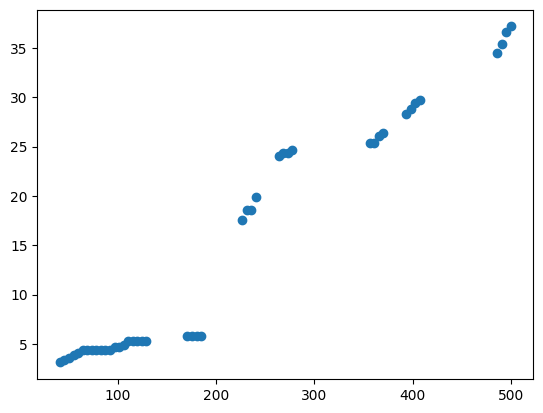

In [ ]:
xpoints = np.array(X)
ypoints = np.array(Y)

plt.plot(xpoints, ypoints, 'o')
plt.show()

# Model 1

In [ ]:
model=pyo.ConcreteModel()

## index sets

In [ ]:
model.Iset=pyo.Set(initialize=range(1,I+1))

## Params

In [ ]:
def rule_X(model, i):
    return X[i-1]
model.X = pyo.Param(model.Iset, initialize=rule_X)

def rule_Y(model, i):
    return Y[i-1]
model.Y = pyo.Param(model.Iset, initialize=rule_Y)

def find_C_down():
  min_c = (model.Y[2] - model.Y[1])/(model.X[2] - model.X[1])
  for i in range(1, I+1):
    for j in range(1, I+1):
      if i > j:
        curr = (model.Y[i] - model.Y[j])/(model.X[i] - model.X[j])
        if curr < min_c:
          min_c = curr
  return min_c

def find_C_up():
  max_c = (model.Y[2] - model.Y[1])/(model.X[2] - model.X[1])
  for i in range(1, I+1):
    for j in range(1, I+1):
      if i > j:
        curr = (model.Y[i] - model.Y[j])/(model.X[i] - model.X[j])
        if curr > max_c:
          max_c = curr
  return max_c

C_up = find_C_up()
C_down = find_C_down()

def find_D_down():
  min_d = (model.Y[1] - C_up*model.X[1])
  for i in range(1, I+1):
      curr = (model.Y[i] - C_up*model.X[i])
      curr2 = (model.Y[i] - C_down*model.X[i])
      if curr < min_d:
        min_d = curr
      if curr2 < min_d:
        min_d = curr2
  return min_d

def find_D_up():
  max_d = (model.Y[1] - C_up*model.X[1])
  for i in range(1, I+1):
      curr = (model.Y[i] - C_up*model.X[i])
      curr2 = (model.Y[i] - C_down*model.X[i])
      if curr > max_d:
        max_d = curr
      if curr2 > max_d:
        max_d = curr2
  return max_d

D_up = find_D_up()
D_down = find_D_down()

# print(C_up, C_down, D_up, D_down)

## Decision variables

In [ ]:
model.c = pyo.Var(bounds=(C_down,C_up))
model.d = pyo.Var(bounds=(D_down,D_up))
model.cesi = pyo.Var(model.Iset, domain = pyo.NonNegativeReals)

## Objective function

In [ ]:
def rule_obj(model):
    return sum(model.cesi[i] for i in model.Iset)
model.obj=pyo.Objective(rule=rule_obj, sense=pyo.minimize)

## Constraints

In [ ]:
def rule_const1(model, i):
    return model.Y[i] - (model.c * model.X[i] + model.d) <= model.cesi[i]
model.const1=pyo.Constraint(model.Iset, rule=rule_const1)

def rule_const2(model, i):
    return  - model.Y[i] + (model.c * model.X[i] + model.d) <= model.cesi[i]
model.const2=pyo.Constraint(model.Iset, rule=rule_const2)

## Solve model and results

In [ ]:
solver=pyo.SolverFactory('cplex_direct')
result = solver.solve(model)
print(result)


Problem: 
- Name: 
  Lower bound: 86.82624975816253
  Upper bound: 86.82624975816253
  Number of objectives: 1
  Number of constraints: 88
  Number of variables: 46
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 46
  Number of nonzeros: None
  Sense: 1
Solver: 
- Name: CPLEX 22.1.1.0
  Status: ok
  Wallclock time: 0.0009369850158691406
  Termination condition: optimal
Solution: 
- number of solutions: 0
  number of solutions displayed: 0



## Draw plot

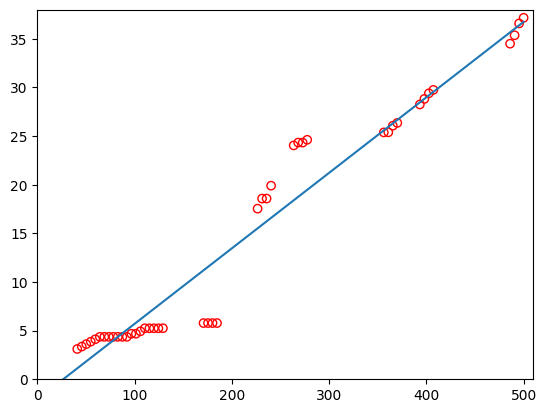

In [ ]:
#plt.plot(xpoints, ypoints, 'o')

# print(model.c.value)
# print(model.d.value)
x = np.linspace(0,500)

fig,ax = plt.subplots()
ax.plot(x,(model.c.value)*x+model.d.value)

ax.set_xlim((0, 510))
ax.set_ylim((0, 38))
plt.scatter(xpoints, ypoints, facecolors='none', edgecolors='r')

plt.show()

# Model 2

In [ ]:
model=pyo.ConcreteModel()

## index sets

In [ ]:
# B can be 2, 3 or 4
B = 3
model.Iset=pyo.Set(initialize=range(1,I+1))
model.Bset=pyo.Set(initialize=range(1,B+1))

## Params

In [ ]:
def rule_X(model, i):
    return X[i-1]
model.X = pyo.Param(model.Iset, initialize=rule_X)

def rule_Y(model, i):
    return Y[i-1]
model.Y = pyo.Param(model.Iset, initialize=rule_Y)

def find_C_down():
  min_c = (model.Y[2] - model.Y[1])/(model.X[2] - model.X[1])
  for i in range(1, I+1):
    for j in range(1, I+1):
      if i > j:
        curr = (model.Y[i] - model.Y[j])/(model.X[i] - model.X[j])
        if curr < min_c:
          min_c = curr
  return min_c

def find_C_up():
  max_c = (model.Y[2] - model.Y[1])/(model.X[2] - model.X[1])
  for i in range(1, I+1):
    for j in range(1, I+1):
      if i > j:
        curr = (model.Y[i] - model.Y[j])/(model.X[i] - model.X[j])
        if curr > max_c:
          max_c = curr
  return max_c

C_up = find_C_up()
C_down = find_C_down()

def find_D_down():
  min_d = (model.Y[1] - C_up*model.X[1])
  for i in range(1, I+1):
      curr = (model.Y[i] - C_up*model.X[i])
      curr2 = (model.Y[i] - C_down*model.X[i])
      if curr < min_d:
        min_d = curr
      if curr2 < min_d:
        min_d = curr2
  return min_d

def find_D_up():
  max_d = (model.Y[1] - C_up*model.X[1])
  for i in range(1, I+1):
      curr = (model.Y[i] - C_up*model.X[i])
      curr2 = (model.Y[i] - C_down*model.X[i])
      if curr > max_d:
        max_d = curr
      if curr2 > max_d:
        max_d = curr2
  return max_d

D_up = find_D_up()
D_down = find_D_down()

def rule_M1(model, i):
  return max(abs(model.Y[i]-C_up*model.X[i] - D_up),
             abs(model.Y[i] - C_up*model.X[i] - D_down),
             abs(model.Y[i] - C_down*model.X[i] - D_up),
             abs(model.Y[i] - C_down*model.X[i] - D_down))
model.M1 = pyo.Param(model.Iset, initialize=rule_M1)

In [ ]:
# for i in range(1, I+1):
#   print(model.M1[i])

## Decisions variables

In [ ]:
model.c = pyo.Var(model.Bset, bounds=(C_down,C_up))
model.d = pyo.Var(model.Bset, bounds=(D_down,D_up))
model.cesi = pyo.Var(model.Iset, domain = pyo.NonNegativeReals)
model.delta = pyo.Var(model.Iset, model.Bset, domain=pyo.Binary)

## Objective function

In [ ]:
def rule_obj(model):
    return sum(model.cesi[i] for i in model.Iset)
model.obj=pyo.Objective(rule=rule_obj, sense=pyo.minimize)

## Constraint

In [ ]:
def rule_const1(model, i, b):
    return model.Y[i] - (model.c[b] * model.X[i] + model.d[b]) <= model.cesi[i] + model.M1[i] * (1-model.delta[i,b])
model.const1=pyo.Constraint(model.Iset, model.Bset, rule=rule_const1)

def rule_const2(model, i, b):
    return  - model.Y[i] + (model.c[b] * model.X[i] + model.d[b]) <= model.cesi[i] + model.M1[i] * (1-model.delta[i,b])
model.const2=pyo.Constraint(model.Iset, model.Bset, rule=rule_const2)

def rule_const3(model, i):
  return sum(model.delta[i, b] for b in model.Bset) == 1
model.const3=pyo.Constraint(model.Iset, rule=rule_const3)

## Solve model and results

In [ ]:
solver=pyo.SolverFactory('cplex_direct')
result = solver.solve(model)
print(result)


Problem: 
- Name: 
  Lower bound: 10.711680456556358
  Upper bound: 10.71271383853654
  Number of objectives: 1
  Number of constraints: 308
  Number of variables: 182
  Number of binary variables: 132
  Number of integer variables: 0
  Number of continuous variables: 50
  Number of nonzeros: None
  Sense: 1
Solver: 
- Name: CPLEX 22.1.1.0
  Status: ok
  Wallclock time: 41.47124361991882
  Termination condition: optimal
Solution: 
- number of solutions: 0
  number of solutions displayed: 0



## Draw plot

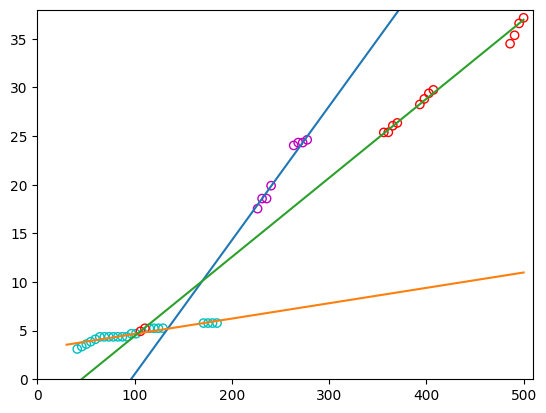

In [ ]:
#plt.plot(xpoints, ypoints, 'o')


x1 = np.linspace(30,500)
x2 = np.linspace(30,500)
x3 = np.linspace(30,500)

fig,ax = plt.subplots()
ax.plot(x1,(model.c[1].value)*x1+model.d[1].value)
ax.plot(x2,(model.c[2].value)*x2+model.d[2].value)
ax.plot(x3,(model.c[3].value)*x3+model.d[3].value)



ax.set_xlim((0, 510))
ax.set_ylim((0, 38))

color = ['m', 'c', 'r', 'k']
for b in model.Bset:
  x = []
  y = []
  for i in model.Iset:
    if model.delta[i,b].value == 1:
      x.append(X[i-1])
      y.append(Y[i-1])
  plt.scatter(np.asarray(x), np.asarray(y), facecolors='none', edgecolors=color[b-1])

plt.show()

# Model 3

In [ ]:
model=pyo.ConcreteModel()

## index sets

In [ ]:
# B can be 2, 3 or 4
B = 3
model.Iset=pyo.Set(initialize=range(1,I+1))
model.Bset=pyo.Set(initialize=range(1,B+1))

## Params

In [ ]:
def rule_X(model, i):
    return X[i-1]
model.X = pyo.Param(model.Iset, initialize=rule_X)

def rule_Y(model, i):
    return Y[i-1]
model.Y = pyo.Param(model.Iset, initialize=rule_Y)

def find_C_down():
  min_c = (model.Y[2] - model.Y[1])/(model.X[2] - model.X[1])
  for i in range(1, I+1):
    for j in range(1, I+1):
      if i > j:
        curr = (model.Y[i] - model.Y[j])/(model.X[i] - model.X[j])
        if curr < min_c:
          min_c = curr
  return min_c

def find_C_up():
  max_c = (model.Y[2] - model.Y[1])/(model.X[2] - model.X[1])
  for i in range(1, I+1):
    for j in range(1, I+1):
      if i > j:
        curr = (model.Y[i] - model.Y[j])/(model.X[i] - model.X[j])
        if curr > max_c:
          max_c = curr
  return max_c

C_up = find_C_up()
C_down = find_C_down()

def find_D_down():
  min_d = (model.Y[1] - C_up*model.X[1])
  for i in range(1, I+1):
      curr = (model.Y[i] - C_up*model.X[i])
      curr2 = (model.Y[i] - C_down*model.X[i])
      if curr < min_d:
        min_d = curr
      if curr2 < min_d:
        min_d = curr2
  return min_d

def find_D_up():
  max_d = (model.Y[1] - C_up*model.X[1])
  for i in range(1, I+1):
      curr = (model.Y[i] - C_up*model.X[i])
      curr2 = (model.Y[i] - C_down*model.X[i])
      if curr > max_d:
        max_d = curr
      if curr2 > max_d:
        max_d = curr2
  return max_d

D_up = find_D_up()
D_down = find_D_down()

def rule_M1(model, i):
  return max(abs(model.Y[i]-C_up*model.X[i] - D_up),
             abs(model.Y[i] - C_up*model.X[i] - D_down),
             abs(model.Y[i] - C_down*model.X[i] - D_up),
             abs(model.Y[i] - C_down*model.X[i] - D_down))
model.M1 = pyo.Param(model.Iset, initialize=rule_M1)

## Decisions variables

In [ ]:
model.c = pyo.Var(model.Bset, bounds=(C_down,C_up))
model.d = pyo.Var(model.Bset, bounds=(D_down,D_up))
model.cesi = pyo.Var(domain = pyo.NonNegativeReals)
model.delta = pyo.Var(model.Iset, model.Bset, domain=pyo.Binary)

## Objective function

In [ ]:
def rule_obj(model):
    return model.cesi
model.obj=pyo.Objective(rule=rule_obj, sense=pyo.minimize)

## Constraint

In [ ]:
def rule_const1(model, i, b):
    return model.Y[i] - (model.c[b] * model.X[i] + model.d[b]) <= model.cesi + model.M1[i]* (1-model.delta[i,b])
model.const1=pyo.Constraint(model.Iset, model.Bset, rule=rule_const1)

def rule_const2(model, i, b):
    return  - model.Y[i] + (model.c[b] * model.X[i] + model.d[b]) <= model.cesi + model.M1[i]* (1-model.delta[i,b])
model.const2=pyo.Constraint(model.Iset, model.Bset, rule=rule_const2)

def rule_const3(model, i):
  return sum(model.delta[i, b] for b in model.Bset) == 1
model.const3=pyo.Constraint(model.Iset, rule=rule_const3)

## Solve model and results

In [ ]:
solver=pyo.SolverFactory('cplex_direct')
result = solver.solve(model)
print(result)


Problem: 
- Name: 
  Lower bound: 0.7772850313373766
  Upper bound: 0.7772850313373766
  Number of objectives: 1
  Number of constraints: 308
  Number of variables: 139
  Number of binary variables: 132
  Number of integer variables: 0
  Number of continuous variables: 7
  Number of nonzeros: None
  Sense: 1
Solver: 
- Name: CPLEX 22.1.1.0
  Status: ok
  Wallclock time: 0.19757580757141113
  Termination condition: optimal
Solution: 
- number of solutions: 0
  number of solutions displayed: 0



## Draw plot

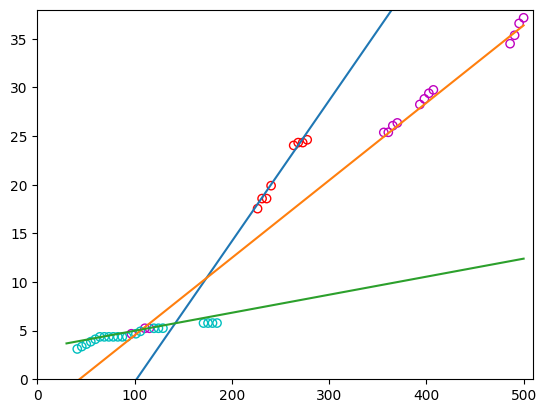

In [ ]:
#plt.plot(xpoints, ypoints, 'o')


x1 = np.linspace(30,500)
x2 = np.linspace(30,500)
x3 = np.linspace(30,500)

fig,ax = plt.subplots()
ax.plot(x1,(model.c[1].value)*x1+model.d[1].value)
ax.plot(x2,(model.c[2].value)*x2+model.d[2].value)
ax.plot(x3,(model.c[3].value)*x3+model.d[3].value)



ax.set_xlim((0, 510))
ax.set_ylim((0, 38))

color = ['r', 'm', 'c', 'k']
for b in model.Bset:
  x = []
  y = []
  for i in model.Iset:
    if model.delta[i,b].value == 1:
      x.append(X[i-1])
      y.append(Y[i-1])
  plt.scatter(np.asarray(x), np.asarray(y), facecolors='none', edgecolors=color[b-1])

plt.show()

# Model 4

In [ ]:
model=pyo.ConcreteModel()

## index sets

In [ ]:
# B can be 2, 3 or 4
B = 3
model.Iset=pyo.Set(initialize=range(1,I+1))
model.Bset=pyo.Set(initialize=range(1,B+1))

## Params

In [ ]:
def rule_X(model, i):
    return X[i-1]
model.X = pyo.Param(model.Iset, initialize=rule_X)

def rule_Y(model, i):
    return Y[i-1]
model.Y = pyo.Param(model.Iset, initialize=rule_Y)

def find_C_down():
  min_c = (model.Y[2] - model.Y[1])/(model.X[2] - model.X[1])
  for i in range(1, I+1):
    for j in range(1, I+1):
      if i > j:
        curr = (model.Y[i] - model.Y[j])/(model.X[i] - model.X[j])
        if curr < min_c:
          min_c = curr
  return min_c

def find_C_up():
  max_c = (model.Y[2] - model.Y[1])/(model.X[2] - model.X[1])
  for i in range(1, I+1):
    for j in range(1, I+1):
      if i > j:
        curr = (model.Y[i] - model.Y[j])/(model.X[i] - model.X[j])
        if curr > max_c:
          max_c = curr
  return max_c

C_up = find_C_up()
C_down = find_C_down()

def find_D_down():
  min_d = (model.Y[1] - C_up*model.X[1])
  for i in range(1, I+1):
      curr = (model.Y[i] - C_up*model.X[i])
      curr2 = (model.Y[i] - C_down*model.X[i])
      if curr < min_d:
        min_d = curr
      if curr2 < min_d:
        min_d = curr2
  return min_d

def find_D_up():
  max_d = (model.Y[1] - C_up*model.X[1])
  for i in range(1, I+1):
      curr = (model.Y[i] - C_up*model.X[i])
      curr2 = (model.Y[i] - C_down*model.X[i])
      if curr > max_d:
        max_d = curr
      if curr2 > max_d:
        max_d = curr2
  return max_d

D_up = find_D_up()
D_down = find_D_down()

def rule_M1(model, i):
  return max(abs(model.Y[i]-C_up*model.X[i] - D_up),
             abs(model.Y[i] - C_up*model.X[i] - D_down),
             abs(model.Y[i] - C_down*model.X[i] - D_up),
             abs(model.Y[i] - C_down*model.X[i] - D_down))
model.M1 = pyo.Param(model.Iset, initialize=rule_M1)

## Decisions variables

In [ ]:
model.c = pyo.Var(model.Bset, bounds=(C_down,C_up))
model.d = pyo.Var(model.Bset, bounds=(D_down,D_up))
model.cesi = pyo.Var(model.Bset, domain = pyo.NonNegativeReals)
model.delta = pyo.Var(model.Iset, model.Bset, domain=pyo.Binary)

## Objective function

In [ ]:
def rule_obj(model):
    return sum(model.cesi[b] for b in model.Bset)
model.obj=pyo.Objective(rule=rule_obj, sense=pyo.minimize)

## Constraint

In [ ]:
def rule_const1(model, i, b):
    return model.Y[i] - (model.c[b] * model.X[i] + model.d[b]) <= model.cesi[b] + model.M1[i] * (1-model.delta[i,b])
model.const1=pyo.Constraint(model.Iset, model.Bset, rule=rule_const1)

def rule_const2(model, i, b):
    return  - model.Y[i] + (model.c[b] * model.X[i] + model.d[b]) <= model.cesi[b] + model.M1[i] * (1-model.delta[i,b])
model.const2=pyo.Constraint(model.Iset, model.Bset, rule=rule_const2)

def rule_const3(model, i):
  return sum(model.delta[i, b] for b in model.Bset) == 1
model.const3=pyo.Constraint(model.Iset, rule=rule_const3)

## Solve model and results

In [ ]:
solver=pyo.SolverFactory('cplex_direct')
result = solver.solve(model)
print(result)


Problem: 
- Name: 
  Lower bound: 1.5587862126170475
  Upper bound: 1.5587862126170475
  Number of objectives: 1
  Number of constraints: 308
  Number of variables: 141
  Number of binary variables: 132
  Number of integer variables: 0
  Number of continuous variables: 9
  Number of nonzeros: None
  Sense: 1
Solver: 
- Name: CPLEX 22.1.1.0
  Status: ok
  Wallclock time: 1.6717135906219482
  Termination condition: optimal
Solution: 
- number of solutions: 0
  number of solutions displayed: 0



## Draw plot

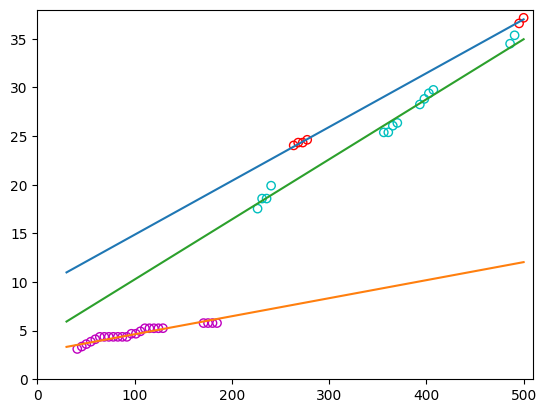

In [ ]:
#plt.plot(xpoints, ypoints, 'o')


x1 = np.linspace(30,500)
x2 = np.linspace(30,500)
x3 = np.linspace(30,500)

fig,ax = plt.subplots()
ax.plot(x1,(model.c[1].value)*x1+model.d[1].value)
ax.plot(x2,(model.c[2].value)*x2+model.d[2].value)
ax.plot(x3,(model.c[3].value)*x3+model.d[3].value)



ax.set_xlim((0, 510))
ax.set_ylim((0, 38))

color = ['r', 'm', 'c', 'k']
for b in model.Bset:
  x = []
  y = []
  for i in model.Iset:
    if model.delta[i,b].value == 1:
      x.append(X[i-1])
      y.append(Y[i-1])
  plt.scatter(np.asarray(x), np.asarray(y), facecolors='none', edgecolors=color[b-1])

plt.show()

# Model 5

In [ ]:
model=pyo.ConcreteModel()

## index sets

In [ ]:
# B can be 2, 3 or 4
B = 3
model.Iset=pyo.Set(initialize=range(1,I+1))
model.Bset=pyo.Set(initialize=range(1,B+1))

## Params

In [ ]:
def rule_X(model, i):
    return X[i-1]
model.X = pyo.Param(model.Iset, initialize=rule_X)

def rule_Y(model, i):
    return Y[i-1]
model.Y = pyo.Param(model.Iset, initialize=rule_Y)

def find_C_down():
  min_c = (model.Y[2] - model.Y[1])/(model.X[2] - model.X[1])
  for i in range(1, I+1):
    for j in range(1, I+1):
      if i > j:
        curr = (model.Y[i] - model.Y[j])/(model.X[i] - model.X[j])
        if curr < min_c:
          min_c = curr
  return min_c

def find_C_up():
  max_c = (model.Y[2] - model.Y[1])/(model.X[2] - model.X[1])
  for i in range(1, I+1):
    for j in range(1, I+1):
      if i > j:
        curr = (model.Y[i] - model.Y[j])/(model.X[i] - model.X[j])
        if curr > max_c:
          max_c = curr
  return max_c

C_up = find_C_up()
C_down = find_C_down()

def find_D_down():
  min_d = (model.Y[1] - C_up*model.X[1])
  for i in range(1, I+1):
      curr = (model.Y[i] - C_up*model.X[i])
      curr2 = (model.Y[i] - C_down*model.X[i])
      if curr < min_d:
        min_d = curr
      if curr2 < min_d:
        min_d = curr2
  return min_d

def find_D_up():
  max_d = (model.Y[1] - C_up*model.X[1])
  for i in range(1, I+1):
      curr = (model.Y[i] - C_up*model.X[i])
      curr2 = (model.Y[i] - C_down*model.X[i])
      if curr > max_d:
        max_d = curr
      if curr2 > max_d:
        max_d = curr2
  return max_d

D_up = find_D_up()
D_down = find_D_down()

def rule_M1(model, i):
  return max(abs(model.Y[i]-C_up*model.X[i] - D_up),
             abs(model.Y[i] - C_up*model.X[i] - D_down),
             abs(model.Y[i] - C_down*model.X[i] - D_up),
             abs(model.Y[i] - C_down*model.X[i] - D_down))
model.M1 = pyo.Param(model.Iset, initialize=rule_M1)

## Decisions variables

In [ ]:
model.c = pyo.Var(model.Bset, bounds=(C_down,C_up))
model.d = pyo.Var(model.Bset, bounds=(D_down,D_up))
model.cesi = pyo.Var(model.Iset, domain = pyo.NonNegativeReals)
model.delta = pyo.Var(model.Iset, model.Bset, domain=pyo.Binary)

## Objective function

In [ ]:
def rule_obj(model):
    return sum(model.cesi[i] for i in model.Iset)
model.obj=pyo.Objective(rule=rule_obj, sense=pyo.minimize)

## Constraint

In [ ]:
def rule_const1(model, i, b):
    return model.Y[i] - (model.c[b] * model.X[i] + model.d[b]) <= model.cesi[i] +model.M1[i] * (1-model.delta[i,b])
model.const1=pyo.Constraint(model.Iset, model.Bset, rule=rule_const1)

def rule_const2(model, i, b):
    return  - model.Y[i] + (model.c[b] * model.X[i] + model.d[b]) <= model.cesi[i] + model.M1[i] * (1-model.delta[i,b])
model.const2=pyo.Constraint(model.Iset, model.Bset, rule=rule_const2)

def rule_const3(model, i):
  return sum(model.delta[i, b] for b in model.Bset) == 1
model.const3=pyo.Constraint(model.Iset, rule=rule_const3)

def rule_const4(model, i, b):
  if i == I:
    return pyo.Constraint.Skip
  elif b == B:
    return pyo.Constraint.Skip
  else:
    return model.delta[i+1, b+1] <= model.delta[i, b] + model.delta[i, b+1]
model.const4=pyo.Constraint(model.Iset, model.Bset,  rule=rule_const4)

def rule_const5(model, i):
  if i == I:
    return pyo.Constraint.Skip
  else:
    return model.delta[i+1, 1] <= model.delta[i, 1]
model.const5=pyo.Constraint(model.Iset, rule=rule_const5)

def rule_const6(model, i):
  if i == I:
    return pyo.Constraint.Skip
  else:
    return model.delta[i, B] <= model.delta[i+1, B]
model.const6=pyo.Constraint(model.Iset, rule=rule_const6)

## Solve model and results

In [ ]:
solver=pyo.SolverFactory('cplex_direct')
result = solver.solve(model)
print(result)


Problem: 
- Name: 
  Lower bound: 11.12923846029217
  Upper bound: 11.12923846029217
  Number of objectives: 1
  Number of constraints: 480
  Number of variables: 182
  Number of binary variables: 132
  Number of integer variables: 0
  Number of continuous variables: 50
  Number of nonzeros: None
  Sense: 1
Solver: 
- Name: CPLEX 22.1.1.0
  Status: ok
  Wallclock time: 0.2534618377685547
  Termination condition: optimal
Solution: 
- number of solutions: 0
  number of solutions displayed: 0



## Draw plot

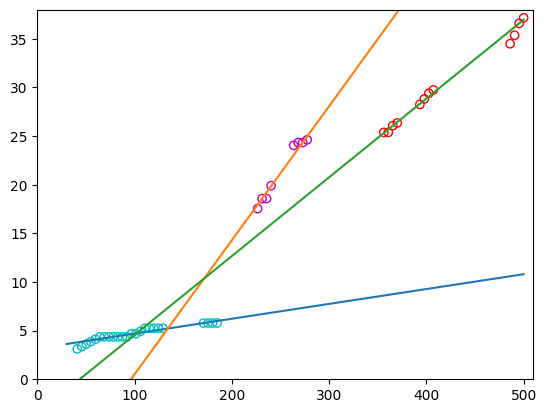

In [ ]:
#plt.plot(xpoints, ypoints, 'o')


x1 = np.linspace(30,500)
x2 = np.linspace(30,500)
x3 = np.linspace(30,500)

fig,ax = plt.subplots()
ax.plot(x1,(model.c[1].value)*x1+model.d[1].value)
ax.plot(x2,(model.c[2].value)*x2+model.d[2].value)
ax.plot(x3,(model.c[3].value)*x3+model.d[3].value)



ax.set_xlim((0, 510))
ax.set_ylim((0, 38))

color = ['c', 'm', 'r', 'k']
for b in model.Bset:
  x = []
  y = []
  for i in model.Iset:
    if model.delta[i,b].value == 1:
      x.append(X[i-1])
      y.append(Y[i-1])
  plt.scatter(np.asarray(x), np.asarray(y), facecolors='none', edgecolors=color[b-1])

plt.show()

#Model 6

In [ ]:
model=pyo.ConcreteModel()

## index sets

In [ ]:
# B can be 3, 4 or 5
B = 3
model.Iset=pyo.Set(initialize=range(1,I+1))
model.Bset=pyo.Set(initialize=range(1,B+1))

## Params

In [ ]:
def rule_X(model, i):
    return X[i-1]
model.X = pyo.Param(model.Iset, initialize=rule_X)

def rule_Y(model, i):
    return Y[i-1]
model.Y = pyo.Param(model.Iset, initialize=rule_Y)

def find_C_down():
  min_c = (model.Y[2] - model.Y[1])/(model.X[2] - model.X[1])
  for i in range(1, I+1):
    for j in range(1, I+1):
      if i > j:
        curr = (model.Y[i] - model.Y[j])/(model.X[i] - model.X[j])
        if curr < min_c:
          min_c = curr
  return min_c

def find_C_up():
  max_c = (model.Y[2] - model.Y[1])/(model.X[2] - model.X[1])
  for i in range(1, I+1):
    for j in range(1, I+1):
      if i > j:
        curr = (model.Y[i] - model.Y[j])/(model.X[i] - model.X[j])
        if curr > max_c:
          max_c = curr
  return max_c

C_up = find_C_up()
C_down = find_C_down()

def find_D_down():
  min_d = (model.Y[1] - C_up*model.X[1])
  for i in range(1, I+1):
      curr = (model.Y[i] - C_up*model.X[i])
      curr2 = (model.Y[i] - C_down*model.X[i])
      if curr < min_d:
        min_d = curr
      if curr2 < min_d:
        min_d = curr2
  return min_d

def find_D_up():
  max_d = (model.Y[1] - C_up*model.X[1])
  for i in range(1, I+1):
      curr = (model.Y[i] - C_up*model.X[i])
      curr2 = (model.Y[i] - C_down*model.X[i])
      if curr > max_d:
        max_d = curr
      if curr2 > max_d:
        max_d = curr2
  return max_d

D_up = find_D_up()
D_down = find_D_down()

def rule_M1(model, i):
  return max(abs(model.Y[i]-C_up*model.X[i] - D_up),
             abs(model.Y[i] - C_up*model.X[i] - D_down),
             abs(model.Y[i] - C_down*model.X[i] - D_up),
             abs(model.Y[i] - C_down*model.X[i] - D_down))
model.M1 = pyo.Param(model.Iset, initialize=rule_M1)

## Decisions variables

In [ ]:
model.c = pyo.Var(model.Bset, bounds=(C_down,C_up))
model.d = pyo.Var(model.Bset, bounds=(D_down,D_up))
model.cesi = pyo.Var(model.Iset, domain = pyo.NonNegativeReals)
model.delta = pyo.Var(model.Iset, model.Bset, domain=pyo.Binary)

## Objective function

In [ ]:
def rule_obj(model):
    return sum(model.cesi[i] for i in model.Iset)
model.obj=pyo.Objective(rule=rule_obj, sense=pyo.minimize)

## Constraint

In [ ]:
def rule_const1(model, i, b):
   if b == B:
      return pyo.Constraint.Skip
   return model.Y[i] - (model.c[b] * model.X[i] + model.d[b]) <= model.cesi[i] + model.M1[i] * (1-model.delta[i,b])
model.const1=pyo.Constraint(model.Iset, model.Bset, rule=rule_const1)

def rule_const2(model, i, b):
  if b == B:
    return pyo.Constraint.Skip
  return  - model.Y[i] + (model.c[b]* model.X[i] + model.d[b]) <= model.cesi[i]
model.const2=pyo.Constraint(model.Iset, model.Bset, rule=rule_const2)

def rule_const3(model, i):
  return sum(model.delta[i, b] for b in model.Bset if b!=B) == 1
model.const3=pyo.Constraint(model.Iset, rule=rule_const3)

def rule_const4(model, b):
  if b == B or b == B-1:
    return pyo.Constraint.Skip
  return model.c[b]<= model.c[b+1]
model.const4=pyo.Constraint(model.Bset, rule=rule_const4)

## Solve model and results

In [ ]:
solver=pyo.SolverFactory('cplex_direct')
result = solver.solve(model)
print(result)


Problem: 
- Name: 
  Lower bound: 66.66212423036006
  Upper bound: 66.66212423036006
  Number of objectives: 1
  Number of constraints: 221
  Number of variables: 182
  Number of binary variables: 132
  Number of integer variables: 0
  Number of continuous variables: 50
  Number of nonzeros: None
  Sense: 1
Solver: 
- Name: CPLEX 22.1.1.0
  Status: ok
  Wallclock time: 1.6224136352539062
  Termination condition: optimal
Solution: 
- number of solutions: 0
  number of solutions displayed: 0



## Draw plot

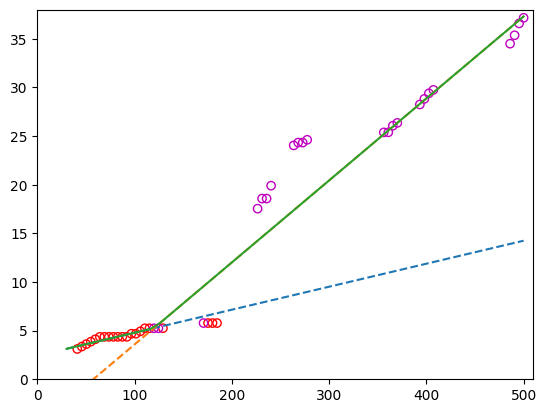

In [ ]:

x1 = np.linspace(30,500)
x2 = np.linspace(30,500)
# x3 = np.linspace(30,500)
# x4 = np.linspace(30,500)

x = np.linspace(30, 500)

fig,ax = plt.subplots()
ax.plot(x1,(model.c[1].value)*x1+model.d[1].value, linestyle = "dashed")
ax.plot(x2,(model.c[2].value)*x2+model.d[2].value, linestyle = "dashed")
# ax.plot(x3,(model.c[3].value)*x3+model.d[3].value, linestyle = "dashed")
# ax.plot(x4,(model.c[4].value)*x3+model.d[4].value, linestyle = "dashed")

ax.plot(x, np.maximum((model.c[1].value)*x+model.d[1].value,
                      (model.c[2].value)*x+model.d[2].value)
                     )



ax.set_xlim((0, 510))
ax.set_ylim((0, 38))

color = ['r', 'm', 'c', 'k']
#plt.plot(xpoints, ypoints, 'o')
for b in range(1, B):
  x = []
  y = []
  for i in model.Iset:
    if model.delta[i,b].value == 1:
      x.append(X[i-1])
      y.append(Y[i-1])
  plt.scatter(np.asarray(x), np.asarray(y), facecolors='none', edgecolors=color[b-1])

plt.show()

#Model 7

In [ ]:
model=pyo.ConcreteModel()

## index sets

In [ ]:
#B can be 3, 4 or 5
B = 5
model.Iset=pyo.Set(initialize=range(1,I+1))
model.Bset=pyo.Set(initialize=range(1,B+1))

## Params

In [ ]:
def rule_X(model, i):
    return X[i-1]
model.X = pyo.Param(model.Iset, initialize=rule_X)

def rule_Y(model, i):
    return Y[i-1]
model.Y = pyo.Param(model.Iset, initialize=rule_Y)

def find_C_down():
  min_c = (model.Y[2] - model.Y[1])/(model.X[2] - model.X[1])
  for i in range(1, I+1):
    for j in range(1, I+1):
      if i > j:
        curr = (model.Y[i] - model.Y[j])/(model.X[i] - model.X[j])
        if curr < min_c:
          min_c = curr
  return min_c

def find_C_up():
  max_c = (model.Y[2] - model.Y[1])/(model.X[2] - model.X[1])
  for i in range(1, I+1):
    for j in range(1, I+1):
      if i > j:
        curr = (model.Y[i] - model.Y[j])/(model.X[i] - model.X[j])
        if curr > max_c:
          max_c = curr
  return max_c

C_up = find_C_up()
C_down = find_C_down()

def find_D_down():
  min_d = (model.Y[1] - C_up*model.X[1])
  for i in range(1, I+1):
      curr = (model.Y[i] - C_up*model.X[i])
      curr2 = (model.Y[i] - C_down*model.X[i])
      if curr < min_d:
        min_d = curr
      if curr2 < min_d:
        min_d = curr2
  return min_d

def find_D_up():
  max_d = (model.Y[1] - C_up*model.X[1])
  for i in range(1, I+1):
      curr = (model.Y[i] - C_up*model.X[i])
      curr2 = (model.Y[i] - C_down*model.X[i])
      if curr > max_d:
        max_d = curr
      if curr2 > max_d:
        max_d = curr2
  return max_d

D_up = find_D_up()
D_down = find_D_down()

def rule_M1(model, i):
  return max(abs(model.Y[i]-C_up*model.X[i] - D_up),
             abs(model.Y[i] - C_up*model.X[i] - D_down),
             abs(model.Y[i] - C_down*model.X[i] - D_up),
             abs(model.Y[i] - C_down*model.X[i] - D_down))
model.M1 = pyo.Param(model.Iset, initialize=rule_M1)

def rule_M2(model, i):
  return D_up-D_down-model.X[i]*(C_down-C_up)
model.M2 = pyo.Param(model.Iset, initialize=rule_M2)

##Decision variables

In [ ]:
model.c = pyo.Var(model.Bset, bounds=(C_down,C_up))
model.d = pyo.Var(model.Bset, bounds=(D_down,D_up))
model.cesi = pyo.Var(model.Iset, domain = pyo.NonNegativeReals)
model.delta = pyo.Var(model.Iset, model.Bset, domain=pyo.Binary)
model.delta_p = pyo.Var(model.Iset, model.Bset, domain=pyo.UnitInterval)
model.delta_n = pyo.Var(model.Iset, model.Bset, domain=pyo.UnitInterval)
model.gama = pyo.Var(model.Bset, domain=pyo.Binary)

## Objective function

In [ ]:
def rule_obj(model):
    return sum(model.cesi[i] for i in model.Iset)
model.obj=pyo.Objective(rule=rule_obj, sense=pyo.minimize)

## Constraint

In [ ]:
def rule_const1(model, i, b):
    return model.Y[i] - (model.c[b] * model.X[i] + model.d[b]) <= model.cesi[i] + model.M1[i] * (1-model.delta[i,b])
model.const1=pyo.Constraint(model.Iset, model.Bset, rule=rule_const1)

def rule_const2(model, i, b):
    return  - model.Y[i] + (model.c[b] * model.X[i] + model.d[b]) <= model.cesi[i] + model.M1[i] * (1-model.delta[i,b])
model.const2=pyo.Constraint(model.Iset, model.Bset, rule=rule_const2)

def rule_const3(model, i):
  return sum(model.delta[i, b] for b in model.Bset if b != B) == 1
model.const3=pyo.Constraint(model.Iset, rule=rule_const3)

def rule_const4(model, i, b):
  if i == I:
    return pyo.Constraint.Skip
  elif b == B:
    return pyo.Constraint.Skip
  else:
    return model.delta[i+1, b+1] <= model.delta[i, b] + model.delta[i, b+1]
model.const4=pyo.Constraint(model.Iset, model.Bset,  rule=rule_const4)

def rule_const5(model, i):
  if i == I:
    return pyo.Constraint.Skip
  else:
    return model.delta[i+1, 1] <= model.delta[i, 1]
model.const5=pyo.Constraint(model.Iset, rule=rule_const5)

def rule_const6(model, i):
  if i == I:
    return pyo.Constraint.Skip
  else:
    return model.delta[i, B] <= model.delta[i+1, B]
model.const6=pyo.Constraint(model.Iset, rule=rule_const6)

def rule_const7(model, i, b):
  if i == I:
    return pyo.Constraint.Skip
  elif b == B or b == B-1:
    return pyo.Constraint.Skip
  else:
    return model.delta[i, b] + model.delta[i+1, b+1] + model.gama[b] - 2 <= model.delta_p[i, b]
model.const7=pyo.Constraint(model.Iset, model.Bset, rule=rule_const7)

def rule_const8(model, i, b):
  if i == I:
    return pyo.Constraint.Skip
  elif b == B or b == B-1:
    return pyo.Constraint.Skip
  else:
    return model.delta[i, b] + model.delta[i+1, b+1] + (1-model.gama[b]) - 2 <= model.delta_n[i, b]
model.const8=pyo.Constraint(model.Iset, model.Bset, rule=rule_const8)

def rule_const9(model, i, b):
  if i == I:
    return pyo.Constraint.Skip
  elif b == B or b == B-1:
    return pyo.Constraint.Skip
  else:
    return model.d[b+1] - model.d[b] >= model.X[i]*(model.c[b]-model.c[b+1]) - model.M2[i]*(1-model.delta_p[i, b])
model.const9=pyo.Constraint(model.Iset, model.Bset, rule=rule_const9)

def rule_const10(model, i, b):
  if i == I:
    return pyo.Constraint.Skip
  elif b == B or b == B-1:
    return pyo.Constraint.Skip
  else:
    return model.d[b+1] - model.d[b] <= model.X[i+1]*(model.c[b]-model.c[b+1]) + model.M2[i+1]*(1-model.delta_p[i, b])
model.const10=pyo.Constraint(model.Iset, model.Bset, rule=rule_const10)

def rule_const11(model, i, b):
  if i == I:
    return pyo.Constraint.Skip
  elif b == B or b == B-1:
    return pyo.Constraint.Skip
  else:
    return model.d[b+1] - model.d[b] <= model.X[i]*(model.c[b]-model.c[b+1]) + model.M2[i]*(1-model.delta_n[i, b])
model.const11=pyo.Constraint(model.Iset, model.Bset, rule=rule_const11)

def rule_const12(model, i, b):
  if i == I:
    return pyo.Constraint.Skip
  elif b == B or b == B-1:
    return pyo.Constraint.Skip
  else:
    return model.d[b+1] - model.d[b] >= model.X[i+1]*(model.c[b]-model.c[b+1]) - model.M2[i+1]*(1-model.delta_n[i, b])
model.const12=pyo.Constraint(model.Iset, model.Bset, rule=rule_const12)

## Solve model and results

In [ ]:
result=pyo.SolverFactory('glpk').solve(model, 'glpk')
print(result)


Problem: 
- Name: unknown
  Lower bound: 10.7453531883832
  Upper bound: 10.7453531883832
  Number of objectives: 1
  Number of constraints: 1516
  Number of variables: 535
  Number of nonzeros: 6236
  Sense: minimize
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 1349
      Number of created subproblems: 1349
  Error rc: 0
  Time: 2.552682638168335
Solution: 
- number of solutions: 0
  number of solutions displayed: 0



In [ ]:
# for i in model.Iset:
#   for b in model.Bset:
#     print("delta:")
#     print(model.delta[i,b].value)
    #print(model.delta_p[i,b].value)
    #print(model.delta_n[i,b].value)

## Draw plot

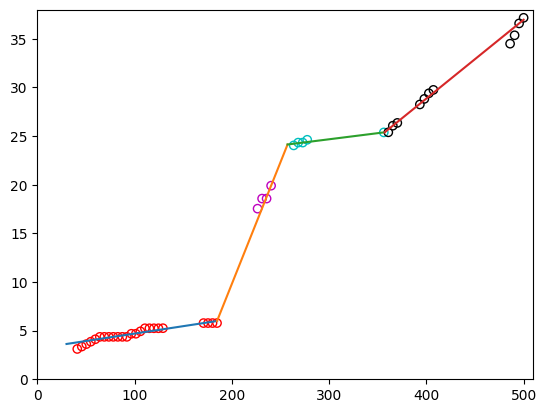

In [ ]:
# for i in range(1, B+1):
#   print(model.d[i].value)
#   print(model.c[i].value)

# print(model.d[3].value - model.d[2].value)
# print(model.c[2].value - model.c[3].value)
# print((model.d[3].value - model.d[2].value)/(model.c[2].value - model.c[3].value))

# print(model.d[2].value - model.d[1].value)
# print(model.c[1].value - model.c[2].value)
# print((model.d[2].value - model.d[1].value)/(model.c[1].value - model.c[2].value))

r1 = (model.d[2].value - model.d[1].value)/(model.c[1].value - model.c[2].value)
r2 = (model.d[3].value - model.d[2].value)/(model.c[2].value - model.c[3].value)
r3 = (model.d[4].value - model.d[3].value)/(model.c[3].value - model.c[4].value)

x1 = np.linspace(30,r1)
x2 = np.linspace(r1,r2)
x3 = np.linspace(r2,r3)
x4 = np.linspace(r3,500)

fig,ax = plt.subplots()
ax.plot(x1,(model.c[1].value)*x1+model.d[1].value)
ax.plot(x2,(model.c[2].value)*x2+model.d[2].value)
ax.plot(x3,(model.c[3].value)*x3+model.d[3].value)
ax.plot(x4,(model.c[4].value)*x4+model.d[4].value)



ax.set_xlim((0, 510))
ax.set_ylim((0, 38))

color = ['r', 'm', 'c', 'k']
#plt.plot(xpoints, ypoints, 'o')
for b in range(1, B):
  x = []
  y = []
  for i in model.Iset:
    if model.delta[i,b].value == 1:
      #print(i, b)
      x.append(X[i-1])
      y.append(Y[i-1])
  plt.scatter(np.asarray(x), np.asarray(y), facecolors='none', edgecolors=color[b-1])

plt.show()

# Model 7(without gamma)

In [ ]:
model=pyo.ConcreteModel()

## index sets

In [ ]:
#B can be 3, 4 or 5
B = 5
model.Iset=pyo.Set(initialize=range(1,I+1))
model.Bset=pyo.Set(initialize=range(1,B+1))

## Params

In [ ]:
def rule_X(model, i):
    return X[i-1]
model.X = pyo.Param(model.Iset, initialize=rule_X)

def rule_Y(model, i):
    return Y[i-1]
model.Y = pyo.Param(model.Iset, initialize=rule_Y)

def find_C_down():
  min_c = (model.Y[2] - model.Y[1])/(model.X[2] - model.X[1])
  for i in range(1, I+1):
    for j in range(1, I+1):
      if i > j:
        curr = (model.Y[i] - model.Y[j])/(model.X[i] - model.X[j])
        if curr < min_c:
          min_c = curr
  return min_c

def find_C_up():
  max_c = (model.Y[2] - model.Y[1])/(model.X[2] - model.X[1])
  for i in range(1, I+1):
    for j in range(1, I+1):
      if i > j:
        curr = (model.Y[i] - model.Y[j])/(model.X[i] - model.X[j])
        if curr > max_c:
          max_c = curr
  return max_c

C_up = find_C_up()
C_down = find_C_down()

def find_D_down():
  min_d = (model.Y[1] - C_up*model.X[1])
  for i in range(1, I+1):
      curr = (model.Y[i] - C_up*model.X[i])
      curr2 = (model.Y[i] - C_down*model.X[i])
      if curr < min_d:
        min_d = curr
      if curr2 < min_d:
        min_d = curr2
  return min_d

def find_D_up():
  max_d = (model.Y[1] - C_up*model.X[1])
  for i in range(1, I+1):
      curr = (model.Y[i] - C_up*model.X[i])
      curr2 = (model.Y[i] - C_down*model.X[i])
      if curr > max_d:
        max_d = curr
      if curr2 > max_d:
        max_d = curr2
  return max_d

D_up = find_D_up()
D_down = find_D_down()

def rule_M1(model, i):
  return max(abs(model.Y[i]-C_up*model.X[i] - D_up),
             abs(model.Y[i] - C_up*model.X[i] - D_down),
             abs(model.Y[i] - C_down*model.X[i] - D_up),
             abs(model.Y[i] - C_down*model.X[i] - D_down))
model.M1 = pyo.Param(model.Iset, initialize=rule_M1)

def rule_M2(model, i):
  return D_up-D_down-model.X[i]*(C_down-C_up)
model.M2 = pyo.Param(model.Iset, initialize=rule_M2)

## Decision variables

In [ ]:
model.c = pyo.Var(model.Bset, bounds=(C_down,C_up))
model.d = pyo.Var(model.Bset, bounds=(D_down,D_up))
model.cesi = pyo.Var(model.Iset, domain = pyo.NonNegativeReals)
model.delta = pyo.Var(model.Iset, model.Bset, domain=pyo.Binary)
model.delta_p = pyo.Var(model.Iset, model.Bset, domain=pyo.Binary)
model.delta_n = pyo.Var(model.Iset, model.Bset, domain=pyo.Binary)

## Objective function

In [ ]:
def rule_obj(model):
    return sum(model.cesi[i] for i in model.Iset)
model.obj=pyo.Objective(rule=rule_obj, sense=pyo.minimize)

## Constraint

In [ ]:
def rule_const1(model, i, b):
    return model.Y[i] - (model.c[b] * model.X[i] + model.d[b]) <= model.cesi[i] + model.M1[i] * (1-model.delta[i,b])
model.const1=pyo.Constraint(model.Iset, model.Bset, rule=rule_const1)

def rule_const2(model, i, b):
    return  - model.Y[i] + (model.c[b] * model.X[i] + model.d[b]) <= model.cesi[i] + model.M1[i] * (1-model.delta[i,b])
model.const2=pyo.Constraint(model.Iset, model.Bset, rule=rule_const2)

def rule_const3(model, i):
  return sum(model.delta[i, b] for b in model.Bset if b != B) == 1
model.const3=pyo.Constraint(model.Iset, rule=rule_const3)

def rule_const4(model, i, b):
  if i == I:
    return pyo.Constraint.Skip
  elif b == B:
    return pyo.Constraint.Skip
  else:
    return model.delta[i+1, b+1] <= model.delta[i, b] + model.delta[i, b+1]
model.const4=pyo.Constraint(model.Iset, model.Bset,  rule=rule_const4)

def rule_const5(model, i):
  if i == I:
    return pyo.Constraint.Skip
  else:
    return model.delta[i+1, 1] <= model.delta[i, 1]
model.const5=pyo.Constraint(model.Iset, rule=rule_const5)

def rule_const6(model, i):
  if i == I:
    return pyo.Constraint.Skip
  else:
    return model.delta[i, B] <= model.delta[i+1, B]
model.const6=pyo.Constraint(model.Iset, rule=rule_const6)


def rule_const9(model, i, b):
  if i == I:
    return pyo.Constraint.Skip
  elif b == B or b == B-1:
    return pyo.Constraint.Skip
  else:
    return model.d[b+1] - model.d[b] >= model.X[i]*(model.c[b]-model.c[b+1]) - model.M2[i]*(1-model.delta_p[i, b])
model.const9=pyo.Constraint(model.Iset, model.Bset, rule=rule_const9)

def rule_const10(model, i, b):
  if i == I:
    return pyo.Constraint.Skip
  elif b == B or b == B-1:
    return pyo.Constraint.Skip
  else:
    return model.d[b+1] - model.d[b] <= model.X[i+1]*(model.c[b]-model.c[b+1]) + model.M2[i+1]*(1-model.delta_p[i, b])
model.const10=pyo.Constraint(model.Iset, model.Bset, rule=rule_const10)

def rule_const11(model, i, b):
  if i == I:
    return pyo.Constraint.Skip
  elif b == B or b == B-1:
    return pyo.Constraint.Skip
  else:
    return model.d[b+1] - model.d[b] <= model.X[i]*(model.c[b]-model.c[b+1]) + model.M2[i]*(1-model.delta_n[i, b])
model.const11=pyo.Constraint(model.Iset, model.Bset, rule=rule_const11)

def rule_const12(model, i, b):
  if i == I:
    return pyo.Constraint.Skip
  elif b == B or b == B-1:
    return pyo.Constraint.Skip
  else:
    return model.d[b+1] - model.d[b] >= model.X[i+1]*(model.c[b]-model.c[b+1]) - model.M2[i+1]*(1-model.delta_n[i, b])
model.const12=pyo.Constraint(model.Iset, model.Bset, rule=rule_const12)

def rule_const13(model, i, b):
  if i == I:
    return pyo.Constraint.Skip
  elif b == B or b == B-1:
    return pyo.Constraint.Skip
  else:
    return model.delta_p[i, b] + model.delta_n[i, b]+ 1 >= model.delta[i, b] + model.delta[i+1, b+1]
model.const13=pyo.Constraint(model.Iset, model.Bset, rule=rule_const13)

## Solve model and results

In [ ]:
result=pyo.SolverFactory('glpk').solve(model, 'glpk')
print(result)


Problem: 
- Name: unknown
  Lower bound: 10.7453531883833
  Upper bound: 10.7453531883833
  Number of objectives: 1
  Number of constraints: 1387
  Number of variables: 532
  Number of nonzeros: 5720
  Sense: minimize
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 3343
      Number of created subproblems: 3343
  Error rc: 0
  Time: 5.453606367111206
Solution: 
- number of solutions: 0
  number of solutions displayed: 0



## Draw plot

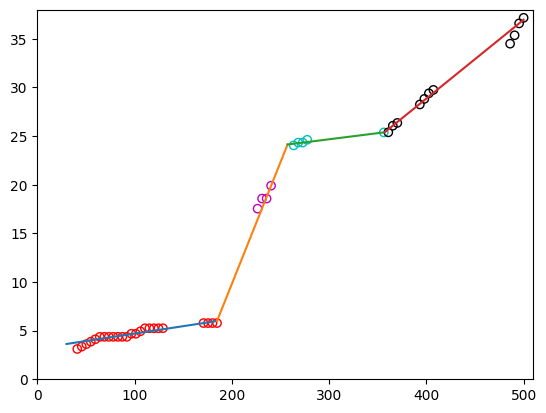

In [ ]:
# for i in range(1, B+1):
#   print(model.d[i].value)
#   print(model.c[i].value)

# print(model.d[3].value - model.d[2].value)
# print(model.c[2].value - model.c[3].value)
# print((model.d[3].value - model.d[2].value)/(model.c[2].value - model.c[3].value))

# print(model.d[2].value - model.d[1].value)
# print(model.c[1].value - model.c[2].value)
# print((model.d[2].value - model.d[1].value)/(model.c[1].value - model.c[2].value))

r1 = (model.d[2].value - model.d[1].value)/(model.c[1].value - model.c[2].value)
r2 = (model.d[3].value - model.d[2].value)/(model.c[2].value - model.c[3].value)
r3 = (model.d[4].value - model.d[3].value)/(model.c[3].value - model.c[4].value)

x1 = np.linspace(30,r1)
x2 = np.linspace(r1,r2)
x3 = np.linspace(r2,r3)
x4 = np.linspace(r3,500)

fig,ax = plt.subplots()
ax.plot(x1,(model.c[1].value)*x1+model.d[1].value)
ax.plot(x2,(model.c[2].value)*x2+model.d[2].value)
ax.plot(x3,(model.c[3].value)*x3+model.d[3].value)
ax.plot(x4,(model.c[4].value)*x4+model.d[4].value)



ax.set_xlim((0, 510))
ax.set_ylim((0, 38))

color = ['r', 'm', 'c', 'k']
#plt.plot(xpoints, ypoints, 'o')
for b in range(1, B):
  x = []
  y = []
  for i in model.Iset:
    if model.delta[i,b].value == 1:
      #print(i, b)
      x.append(X[i-1])
      y.append(Y[i-1])
  plt.scatter(np.asarray(x), np.asarray(y), facecolors='none', edgecolors=color[b-1])

plt.show()